In [1]:
# 1MBA (myoglobin)
#seq = "SLSAAEADLAGKSWAPVFANKNANGLDFLVALFEKFPDSANFFADFKGKSVADIKASPKLRDVSSRIFTRLNEFVNNAANAGKMSAMLSQFAKEHVGFGVGSAQFENVRSMFPGFVASVAAPPAGADAAWTKLFGLIIDALKAAGA"

# 1MJC
seq = "SGKMTGIVKWFNADKGFGFITPDDGSKDVFVHFSAIQNDGYKSLDEGQKVSFTIESGAKGPAAGNVTSL"

with open("ss.a3m", "w") as f:
    f.write(f">test\n{seq}\n")

header = f"test|protein|ss.a3m"

with open("ss.fasta", "w") as f:
    f.write(f">{header}\n{seq}\n")



In [2]:
num_samples = 24
%run /home/gridsan/jroney/solab/af3/FoldScaling/boltz/src/boltz/main.py predict ss.fasta --diffusion_samples {num_samples} --override --skip_pred

Checking input data.
Found existing predictions, will override.
Running predictions for 1 structure
Processing input data.
Found a manifest file at output directory: boltz_results_ss
All examples in data are processed. Updating the manifest


/home/gridsan/jroney/.conda/envs/boltz1/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.11 /home/gridsan/jroney/solab/af3/FoldScaling/boltz ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Skipping prediction step as requested.


/home/gridsan/jroney/.conda/envs/boltz1/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [3]:
processed = _boltz_inputs
data_module = BoltzInferenceDataModule(
    manifest=processed.manifest,
    target_dir=processed.targets_dir,
    msa_dir=processed.msa_dir,
    num_workers=1,
    constraints_dir=processed.constraints_dir,
)

batch = next(iter(data_module.predict_dataloader()))
batch = {k:v.cuda() if torch.is_tensor(v) else v for k,v in batch.items()}
model = _boltz_module.cuda()

In [4]:
trunk_out = model(
        batch,
        recycling_steps=model.predict_args["recycling_steps"],
        num_sampling_steps=model.predict_args["sampling_steps"],
        diffusion_samples=num_samples,
        return_final_reps=True,
        skip_diffusion=True)

In [5]:
diff_outputs = model.structure_module.sample(
                    s_trunk=trunk_out['s_trunk'],
                    z_trunk=trunk_out['z_trunk'],
                    s_inputs=trunk_out['s_inputs'],
                    feats=trunk_out['feats'],
                    relative_position_encoding=trunk_out['relative_position_encoding'],
                    num_sampling_steps=model.predict_args["sampling_steps"],
                    atom_mask=trunk_out['feats']["atom_pad_mask"],
                    multiplicity=num_samples,
                    train_accumulate_token_repr=model.training,
                    steering_args={'fk_steering' : False, 'guidance_update': False},
                    custom_noise=None,
                    custom_potentials=[]
                )

In [6]:
model.confidence_module.use_s_diffusion=False
conf_out = model.confidence_module(
        s_inputs=trunk_out['s_trunk'],
        s=trunk_out['s_trunk'],
        z=trunk_out['z_trunk'],
        s_diffusion=None,
        x_pred=diff_outputs['sample_atom_coords'],
        feats=trunk_out['feats'],
        pred_distogram_logits=trunk_out["pdistogram"],
        multiplicity=model.predict_args["diffusion_samples"],
        run_sequentially=False
    )

(array([1., 1., 2., 0., 4., 5., 3., 4., 1., 3.]),
 array([0.44270706, 0.44762939, 0.45255172, 0.45747408, 0.46239641,
        0.46731874, 0.47224107, 0.4771634 , 0.48208576, 0.48700809,
        0.49193043]),
 <BarContainer object of 10 artists>)

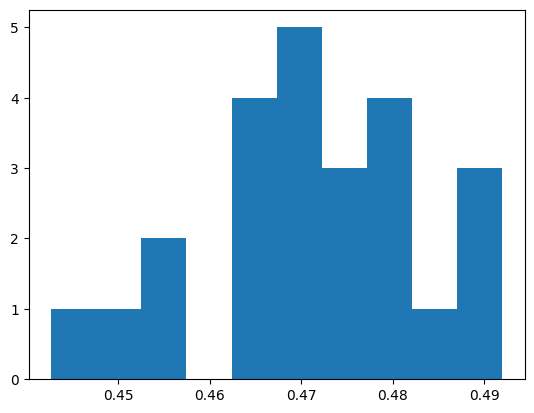

In [7]:
import matplotlib.pyplot as plt

conf_score = (4*conf_out['complex_plddt'] + conf_out['ptm']).cpu().numpy() /5
plt.hist(conf_score)

In [29]:
from boltz.model.potentials.potentials import Potential

"""
Class for FK guidance with confidence module as guiding potential
"""

model.steering_args['num_particles']=4
model.steering_args['fk_lambda']=20
model.steering_args['fk_resampling_interval']=5
model.steering_args['guidance_update']=False
model.steering_args['max_fk_noise'] = 100
model.steering_args['potential_type'] = "vanilla"
model.steering_args['noise_coord_potential'] = False

class BoltzConfidencePotential(Potential):

    def compute_args(self, feats, params):
        return None, (), None # dummy return vals
    
    def compute_variable(self, coords, index, compute_gradient=False):

            
        conf_out = model.confidence_module(
                s_inputs=trunk_out['s_trunk'],
                s=trunk_out['s_trunk'],
                z=trunk_out['z_trunk'],
                s_diffusion=None,
                x_pred=coords,
                feats=trunk_out['feats'],
                pred_distogram_logits=trunk_out["pdistogram"],
                multiplicity=model.predict_args["diffusion_samples"] * model.steering_args['num_particles'],
                run_sequentially=False
            )

        conf_score = (4*conf_out['complex_plddt'] + conf_out['ptm']) / 5
        conf_score = conf_score.unsqueeze(-1) # this is important because it expects the energy to have many contributions from different indices

        print(conf_score)
        if not compute_gradient:
            return conf_score

        return conf_score, torch.zeros_like(coords) # we can't get a gradient because the prediction is turned into a binned dgram
        
    # def compute_function(self, value, compute_derivative=False):
    #     nrg = -torch.log(value)
    #     if not compute_derivative:
    #         return nrg
        
    #     return nrg, -1/nrg

    def compute_function(self, value, compute_derivative=False):
        nrg = 1-value
        if not compute_derivative:
            return nrg
        
        return nrg, -value

        
        

In [30]:
pot = BoltzConfidencePotential(parameters={
                'guidance_interval': 5,
                'guidance_weight': 0.00,
                'resampling_weight': 1.0,
            })

In [31]:
model.steering_args

{'fk_steering': True,
 'num_particles': 4,
 'fk_lambda': 20,
 'fk_resampling_interval': 5,
 'guidance_update': False,
 'num_gd_steps': 16,
 'max_fk_noise': 100,
 'potential_type': 'vanilla',
 'noise_coord_potential': False}

In [32]:
diff_outputs_guided = model.structure_module.sample(
                        s_trunk=trunk_out['s_trunk'],
                        z_trunk=trunk_out['z_trunk'],
                        s_inputs=trunk_out['s_inputs'],
                        feats=trunk_out['feats'],
                        relative_position_encoding=trunk_out['relative_position_encoding'],
                        num_sampling_steps=model.predict_args["sampling_steps"],
                        atom_mask=trunk_out['feats']["atom_pad_mask"],
                        multiplicity=num_samples,
                        train_accumulate_token_repr=model.training,
                        steering_args=model.steering_args,
                        custom_noise=None,
                        custom_potentials=[pot]
                    )

85.69275665283203
tensor([[0.4845],
        [0.4811],
        [0.4929],
        [0.4792],
        [0.4843],
        [0.4915],
        [0.4937],
        [0.4866],
        [0.4817],
        [0.4869],
        [0.4892],
        [0.4895],
        [0.4821],
        [0.4832],
        [0.4863],
        [0.4806],
        [0.4806],
        [0.4893],
        [0.4834],
        [0.4744],
        [0.4938],
        [0.4933],
        [0.4845],
        [0.4922],
        [0.4912],
        [0.4784],
        [0.4904],
        [0.4940],
        [0.4903],
        [0.4852],
        [0.4808],
        [0.4952],
        [0.4785],
        [0.4865],
        [0.4860],
        [0.4821],
        [0.4830],
        [0.4906],
        [0.4729],
        [0.4901],
        [0.4936],
        [0.4886],
        [0.4830],
        [0.4923],
        [0.4934],
        [0.4845],
        [0.4853],
        [0.4887],
        [0.4924],
        [0.4934],
        [0.4816],
        [0.4863],
        [0.4815],
        [0.4822],
        [0

In [33]:
conf_out_guided = model.confidence_module(
        s_inputs=trunk_out['s_trunk'],
        s=trunk_out['s_trunk'],
        z=trunk_out['z_trunk'],
        s_diffusion=None,
        x_pred=diff_outputs_guided['sample_atom_coords'],
        feats=trunk_out['feats'],
        pred_distogram_logits=trunk_out["pdistogram"],
        multiplicity=model.predict_args["diffusion_samples"],
        run_sequentially=False
    )

(array([2., 1., 6., 4., 6., 3., 0., 1., 0., 1.]),
 array([0.45487738, 0.46188855, 0.46889976, 0.47591093, 0.48292214,
        0.48993331, 0.49694449, 0.50395566, 0.5109669 , 0.51797807,
        0.52498925]),
 <BarContainer object of 10 artists>)

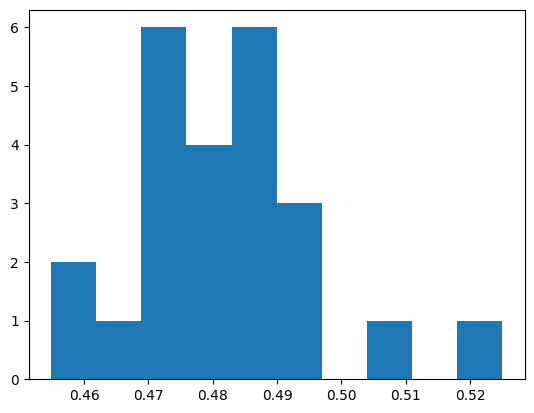

In [34]:
conf_score = (4*conf_out_guided['complex_plddt'] + conf_out_guided['ptm']).cpu().numpy() /5
plt.hist(conf_score)

(array([1., 1., 2., 0., 4., 5., 3., 4., 1., 3.]),
 array([0.44270706, 0.44762939, 0.45255172, 0.45747408, 0.46239641,
        0.46731874, 0.47224107, 0.4771634 , 0.48208576, 0.48700809,
        0.49193043]),
 <BarContainer object of 10 artists>)

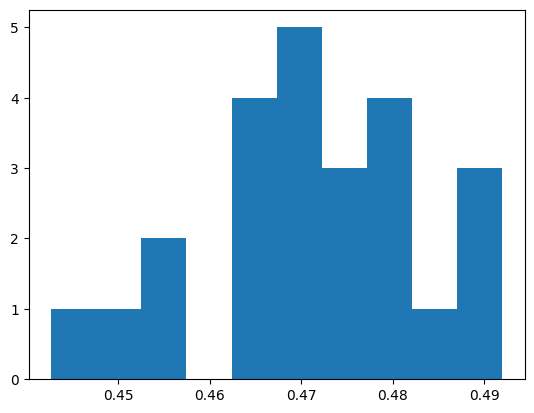

In [35]:
conf_score = (4*conf_out['complex_plddt'] + conf_out['ptm']).cpu().numpy() / 5
plt.hist(conf_score)

In [17]:
conf_out['complex_plddt']

tensor([0.5408, 0.5273, 0.5710, 0.5550, 0.5211, 0.5555, 0.5531, 0.5369, 0.5160,
        0.5246, 0.5441, 0.5286, 0.5452, 0.5179, 0.5223, 0.5540, 0.5358, 0.5166,
        0.5417, 0.5353, 0.5329, 0.5368, 0.5208, 0.5147], device='cuda:0')

In [18]:
conf_out_guided['complex_plddt']

tensor([0.5490, 0.5291, 0.5304, 0.5286, 0.5210, 0.5320, 0.5265, 0.5402, 0.5666,
        0.5222, 0.5391, 0.5153, 0.5550, 0.5223, 0.5409, 0.5421, 0.5403, 0.5612,
        0.5190, 0.5275, 0.5209, 0.5440, 0.5530, 0.5425], device='cuda:0')

In [26]:
model.structure_module.num_sampling_steps

5